In [180]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from utils import *

datasets_folder = './datasets'
starting_date = datetime(2019,1,1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
air_pollution_dataset = os.path.join(datasets_folder,'pollution/pollution.csv')

air_pollution_df = pd.read_csv(air_pollution_dataset, sep=';')
air_pollution_df.rename(columns={
    'COD_STAZ': 'Station', 
    'AGENTE': 'Agent', 
    'DATA_INIZIO': 'Date', 
    'DATA_FINE': 'Ending_date', 
    'VALORE': 'Value', 
    'UM': 'Unit'
}, inplace=True)

air_pollution_df.drop(columns=['Ending_date'], inplace=True)
air_pollution_df=air_pollution_df.sort_values(by='Date')
air_pollution_df['Date'] = pd.to_datetime(air_pollution_df['Date'].apply(lambda x: ' '.join(x.split('T')).split('+')[0]))
air_pollution_df['Agent'] = air_pollution_df['Agent'].apply(lambda x: x.split(' ')[0])

air_pollution_df.head(3)

,Station,Agent,Date,Value,Unit
153710,GIARDINI MARGHERITA,O3,2019-01-01 00:01:00,2.0,ug/m3
285790,PORTA SAN FELICE,NO,2019-01-01 00:01:00,97.0,ug/m3
129202,GIARDINI MARGHERITA,NO2,2019-01-01 00:01:00,29.0,ug/m3


## Station estimations

In [98]:
giardini_df = air_pollution_df[air_pollution_df['Station'] == 'GIARDINI MARGHERITA']
san_felice_df = air_pollution_df[air_pollution_df['Station'] == 'PORTA SAN FELICE']
chiarini_df = air_pollution_df[air_pollution_df['Station'] == 'VIA CHIARINI']

### Giardini Margherita

In [108]:
for agent in np.unique(giardini_df['Agent']):
    mask=(giardini_df['Agent']==agent)
    timedeltas_hours = giardini_df['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    print(f'Agent: {agent}')
    print(timedeltas_hours.value_counts().head(5))

Agent: NO2
Date
1.0    50984
2.0      449
3.0       23
9.0        4
5.0        3
Name: count, dtype: int64
Agent: O3
Date
1.0    51555
2.0      134
3.0       20
0.0        6
4.0        6
Name: count, dtype: int64
Agent: PM10
Date
24.0    2038
23.0      12
25.0      12
48.0      12
72.0      11
Name: count, dtype: int64
Agent: PM2.5
Date
24.0    2071
48.0      13
23.0      12
25.0      12
72.0       6
Name: count, dtype: int64


Resample (modify dataframe to have a dense index and add also to each row the missing values for station and Unit(not really necessary anyway))
PM are resampled at 24h, other agents at 1h

In [199]:
giardini_agents_dict = {
    'PM10': '24h',
    'PM2.5': '24h',
    'NO2': '1h',
    'O3': '1h'
}

resampled_giardini_df = resample_df_on_column(giardini_df, giardini_agents_dict)
resampled_giardini_df[resampled_giardini_df['Agent'] == 'NO2'].head()


Resampling PM10 on 24h
Resampling PM2.5 on 24h
Resampling NO2 on 1h
Resampling O3 on 1h


,Date,Station,Agent,Value,Unit
0,2019-01-01 00:00:00,GIARDINI MARGHERITA,NO2,29.0,ug/m3
1,2019-01-01 01:00:00,GIARDINI MARGHERITA,NO2,NaN,ug/m3
2,2019-01-01 02:00:00,GIARDINI MARGHERITA,NO2,23.0,ug/m3
3,2019-01-01 03:00:00,GIARDINI MARGHERITA,NO2,29.0,ug/m3
4,2019-01-01 04:00:00,GIARDINI MARGHERITA,NO2,26.0,ug/m3


Added the missing rows but still the value is Nan

In [200]:
print(len(resampled_giardini_df[resampled_giardini_df['Agent'] == 'NO2']))
print(len(resampled_giardini_df[resampled_giardini_df['Agent'] == 'PM10']))
print(len(resampled_giardini_df[resampled_giardini_df['Agent'] == 'PM2.5']))
print(len(resampled_giardini_df[resampled_giardini_df['Agent'] == 'O3']))

52608
2192
2192
52608


Just a check to see that now all the rows are present.

In [201]:
# start=datetime(2020,10,2)
# end=datetime(2025,10,10)

# for agent in np.unique(resampled_giardini_df['Agent']):
#     mask=(resampled_giardini_df['Agent']==agent)&(resampled_giardini_df['Date']>start)&(resampled_giardini_df['Date']<end)
#     timedeltas_hours = resampled_giardini_df['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours

#     plt.figure(figsize=(40, 5))
#     plt.plot(resampled_giardini_df['Date'][mask][1:], timedeltas_hours, marker='o', linestyle='-')
#     plt.xlabel('Datetime')
#     plt.ylim(0,max(timedeltas_hours)+1)
#     plt.ylabel('Time Difference (hours)')
#     plt.title(f'{agent}')
#     plt.xticks(rotation=45)  # Rotate labels for better readability
#     plt.grid(True)
#     plt.show()

Plot to see the difference between the original data that seem to not have missing values and the resampled data where their location is clearly visibile. Those values can easily be filled with forward or backward filling.

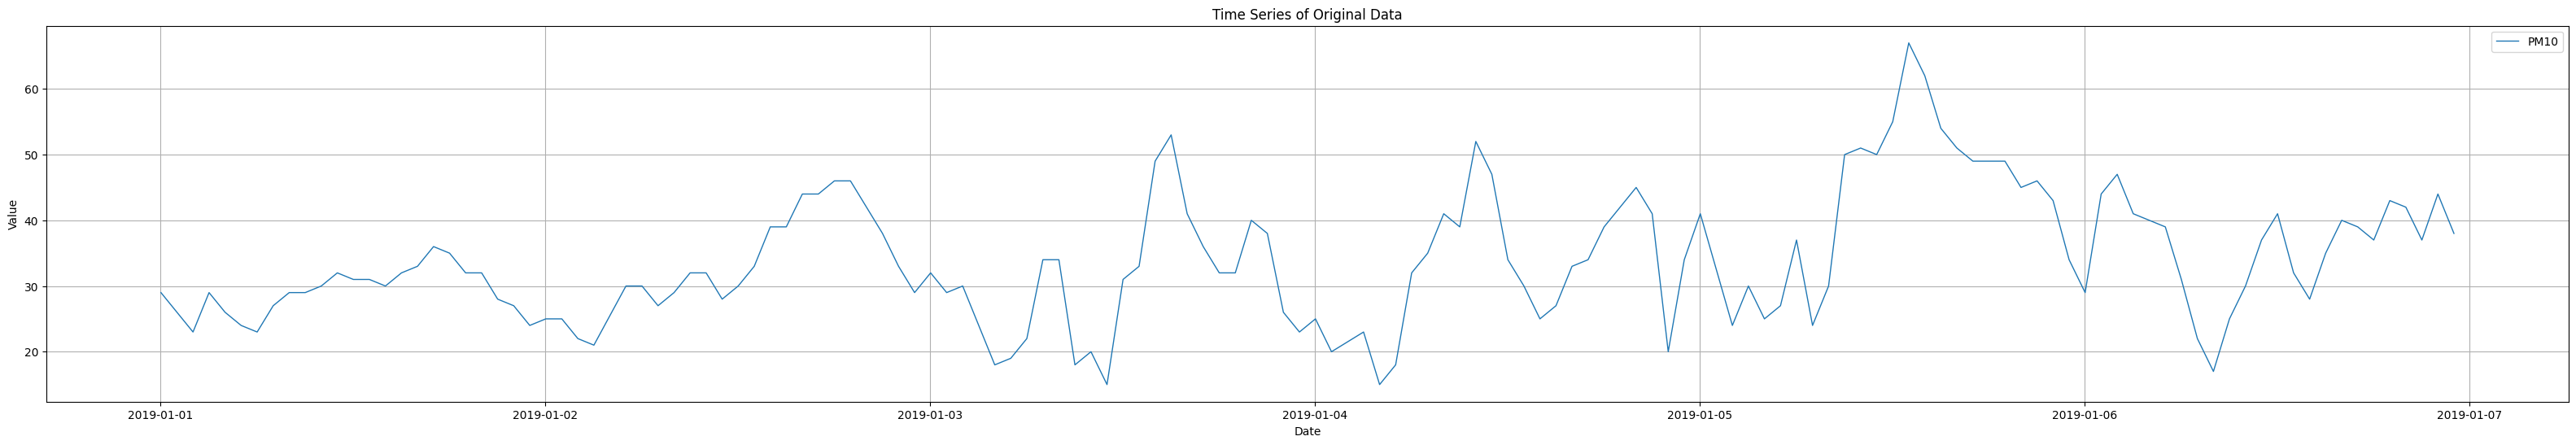

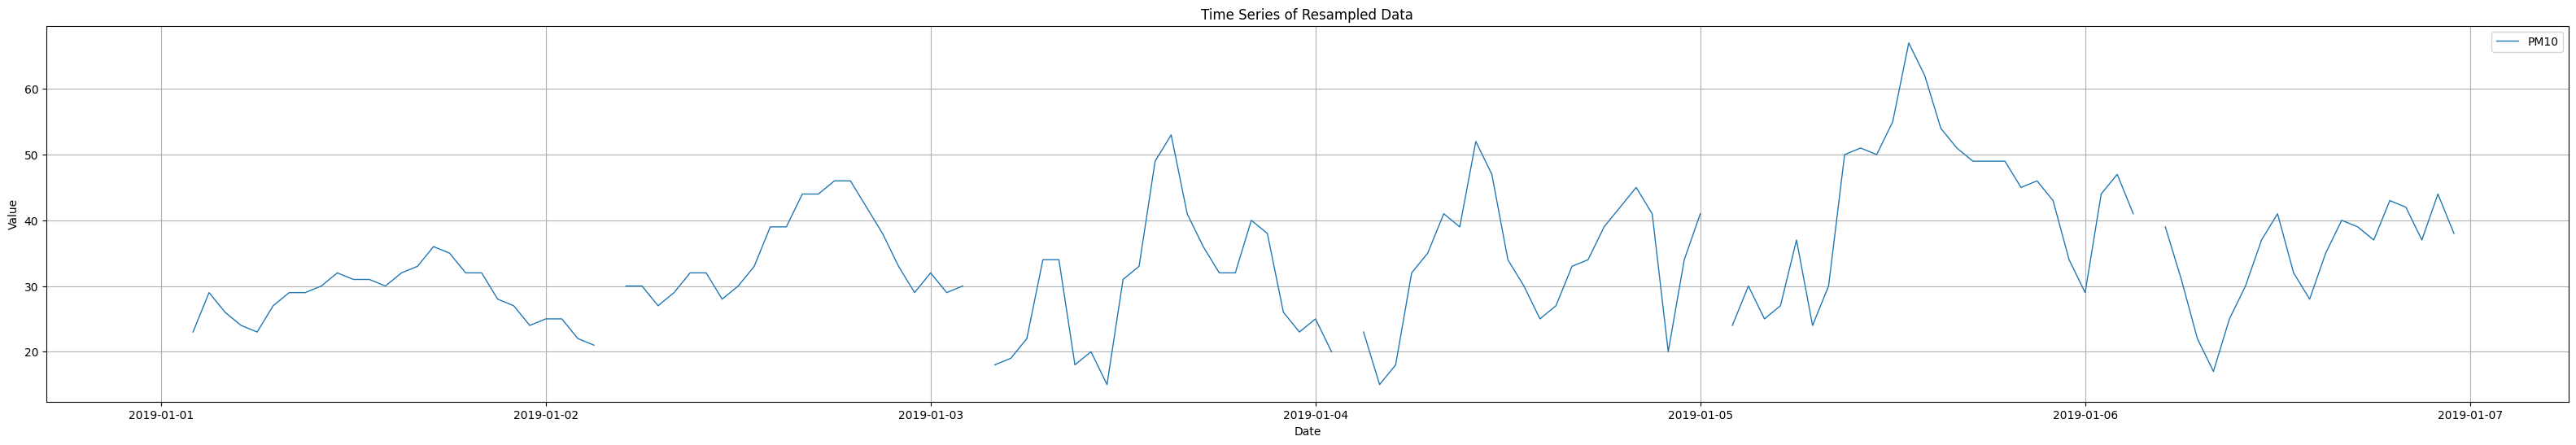

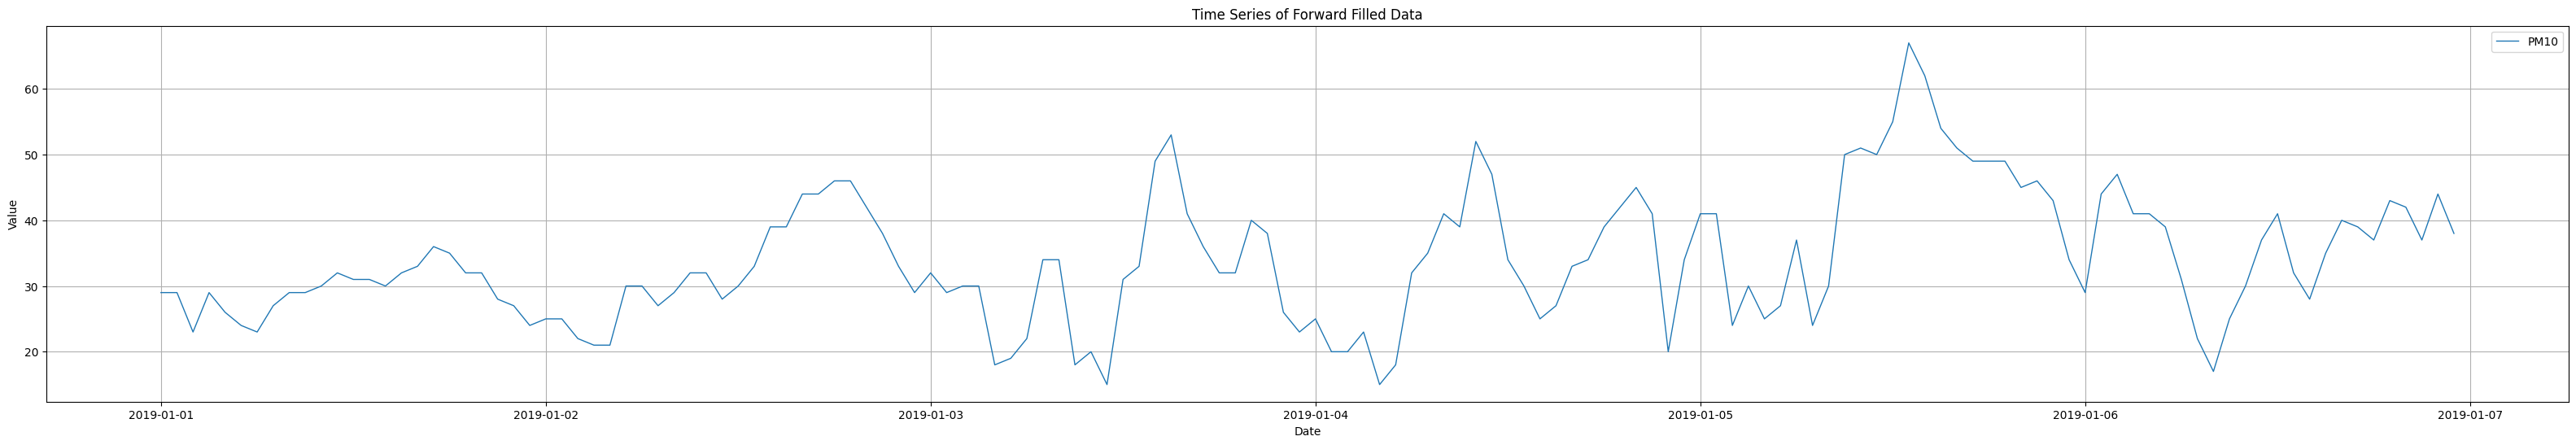

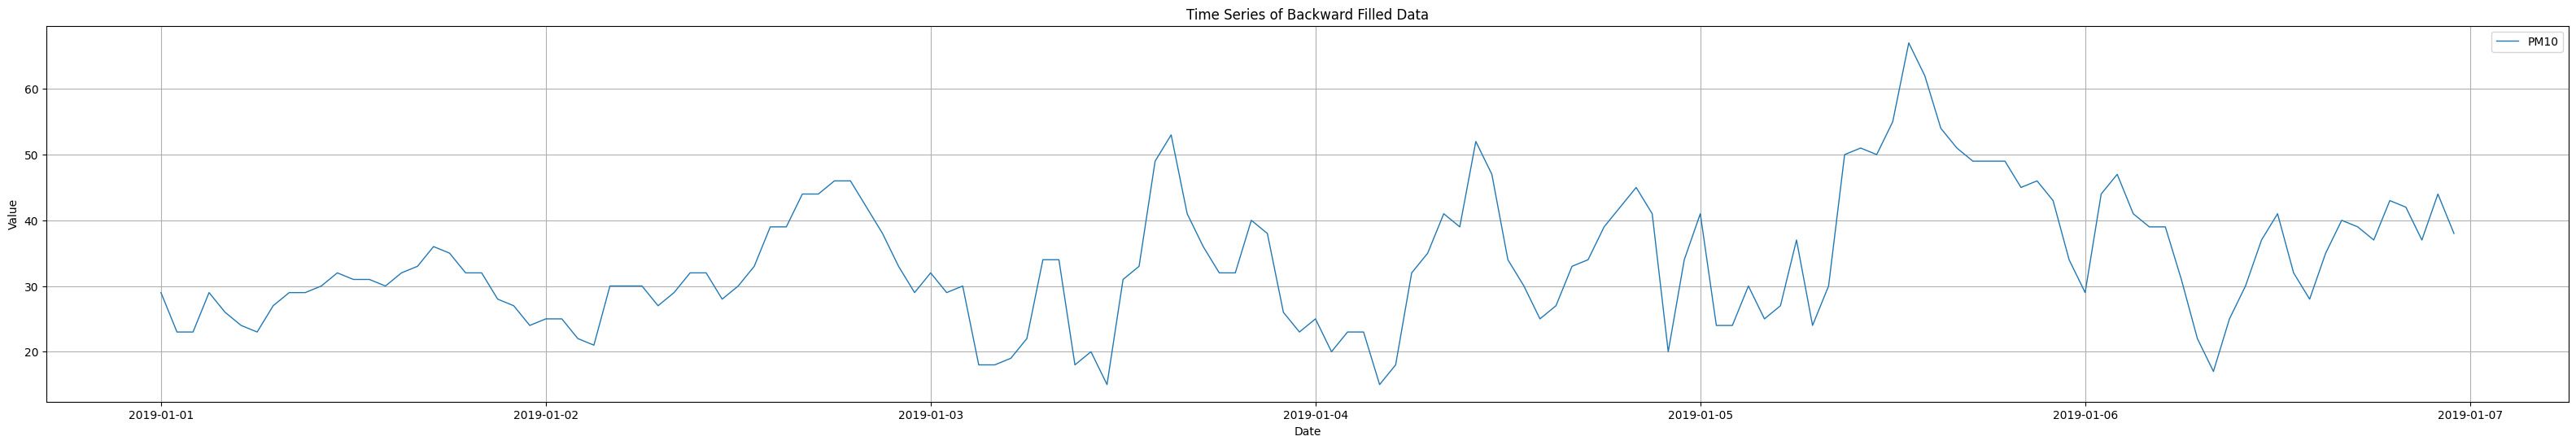

In [202]:
start_date=datetime(2018,10,3)
end_date=datetime(2019,1,7)

plot_time_series([giardini_df[giardini_df['Agent']=='NO2']], 'Value', 'Date', legends=['PM10', 'PM2.5'], start_date=start_date, end_date=end_date, title='Original Data')
plot_time_series([resampled_giardini_df[resampled_giardini_df['Agent']=='NO2']], 'Value', 'Date', legends=['PM10', 'PM2.5'], start_date=start_date, end_date=end_date, title='Resampled Data')

plot_time_series([resampled_giardini_df[resampled_giardini_df['Agent']=='NO2'].ffill()], 'Value', 'Date', legends=['PM10', 'PM2.5'], start_date=start_date, end_date=end_date, title='Forward Filled Data')

plot_time_series([resampled_giardini_df[resampled_giardini_df['Agent']=='NO2'].bfill()], 'Value', 'Date', legends=['PM10', 'PM2.5'], start_date=start_date, end_date=end_date, title='Backward Filled Data')

Choose for forward fill

In [203]:
resampled_giardini_df.isna().sum()

Date          0
Station       0
Agent         0
Value      2169
Unit          0
dtype: int64

In [204]:
filled_giardini_df = fill_missing_dates(resampled_giardini_df, mode='ffill')
filled_giardini_df.isna().sum()

Date       0
Station    0
Agent      0
Value      0
Unit       0
dtype: int64

### Train-Test split

In [206]:
split_date = datetime(2024, 1, 1)
train_giardini_df, test_giardini_df = filled_giardini_df[filled_giardini_df['Date'] < split_date], filled_giardini_df[filled_giardini_df['Date'] >= split_date]
train_giardini_df.shape, test_giardini_df.shape

((91300, 5), (18300, 5))

### Porta San Felice

### Via Chiarini